In [1]:
!pip install python-dotenv

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from datetime import datetime, timedelta
import time
import os
import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv('PolygonAPI.env')


True

In [3]:
POLYGON_API_KEY = os.getenv("POLYGON_API_KEY", "")

print(f"API Key loaded: {POLYGON_API_KEY[:10]}..." if POLYGON_API_KEY else "❌ NOT LOADED")

API Key loaded: i0mFBg4ssj...


In [4]:
ALL_TICKERS = {
    'AI Infrastructure': ['NVDA', 'AMD', 'INTC', 'MU', 'CORW', 'NBIS', 'GOOGL'],
    'Robotics & Space': ['RKLB', 'JOBY', 'ACHR', 'TSLA'],
    'Crypto': ['COIN', 'HOOD', 'IBIT', 'IREN', 'CLSK'],
    'Quantum': ['IONQ', 'RGTI', 'QBTS', 'SMR', 'SERV']
}

FLAT_TICKERS = [t for sleeve in ALL_TICKERS.values() for t in sleeve]

START_DATE = '2015-01-01' 
END_DATE = '2025-10-11'

INITIAL_CAPITAL = 100000
TOP_N_PER_SLEEVE = 2
LOOKBACK_PERIOD = 90

TRANSACTION_COSTS = {
    'bid_ask_spread': 10,      
    'market_impact': 5,         
    'commission': 0            
}
TOTAL_TRANSACTION_COST_BPS = sum(TRANSACTION_COSTS.values()) 

print(f"Stocks to fetch: {len(FLAT_TICKERS)}")
print(f"Date range: {START_DATE} to {END_DATE} (10 YEARS)")
print(f"Transaction costs: {TOTAL_TRANSACTION_COST_BPS} bps per trade")
print()


Stocks to fetch: 21
Date range: 2015-01-01 to 2025-10-11 (10 YEARS)
Transaction costs: 15 bps per trade



In [5]:
def fetch_polygon_data(ticker, start_date, end_date, api_key):
    """Fetch daily OHLC data from Polygon.io"""
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}"
    params = {
        'adjusted': 'true',
        'sort': 'asc',
        'limit': 50000,
        'apiKey': api_key
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()
        
        if 'results' not in data:
            print(f"[{ticker}] No data available")
            return None
        
        df = pd.DataFrame(data['results'])
        df['date'] = pd.to_datetime(df['t'], unit='ms')
        df = df.set_index('date')[['c']]
        df.columns = [ticker]
        
        print(f"[{ticker}] ✅ {len(df)} days")
        return df[ticker]
    except Exception as e:
        print(f"[{ticker}] Error: {str(e)}")
        return None

In [6]:
data_dict = {}
for ticker in FLAT_TICKERS:
    series = fetch_polygon_data(ticker, START_DATE, END_DATE, POLYGON_API_KEY)
    if series is not None:
        data_dict[ticker] = series
    time.sleep(0.15)

data = pd.DataFrame(data_dict)

print(f"Stocks: {len(data.columns)}/{len(FLAT_TICKERS)}")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"Shape: {data.shape}")

missing = [t for t in FLAT_TICKERS if t not in data.columns]
if missing:
    print(f"\nMissing tickers: {', '.join(missing)}")
    print("These will be excluded from analysis.")

data = data.fillna(method='ffill').fillna(method='bfill')
min_stocks_required = len(data.columns) * 0.5
data = data.dropna(thresh=min_stocks_required)

print(f"\nAfter cleaning: {data.shape[0]} days with {data.shape[1]} stocks")

data.to_csv('attf_polygon_data_extended.csv')
print(f"\nSaved to 'attf_polygon_data_extended.csv'")

[NVDA] ✅ 2512 days
[AMD] ✅ 2512 days
[INTC] ✅ 2512 days
[MU] ✅ 2512 days
[CORW] No data available
[NBIS] ✅ 244 days
[GOOGL] ✅ 2512 days
[RKLB] ✅ 1037 days
[JOBY] ✅ 1047 days
[ACHR] ✅ 1021 days
[TSLA] ✅ 2512 days
[COIN] ✅ 1130 days
[HOOD] ✅ 1056 days
[IBIT] ✅ 601 days
[IREN] ✅ 978 days
[CLSK] ✅ 1436 days
[IONQ] ✅ 1011 days
[RGTI] ✅ 907 days
[QBTS] ✅ 798 days
[SMR] ✅ 864 days
[SERV] ✅ 1623 days
Stocks: 20/21
Date range: 2015-10-15 to 2025-10-10
Shape: (2512, 20)

Missing tickers: CORW
These will be excluded from analysis.

After cleaning: 2512 days with 20 stocks

Saved to 'attf_polygon_data_extended.csv'


In [7]:

def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    """Calculate annualized Sharpe ratio"""
    if returns.std() == 0:
        return 0
    excess_returns = returns - risk_free_rate
    return (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)

def calculate_sortino_ratio(returns, risk_free_rate=0.0):
    """Calculate Sortino ratio (downside deviation only)"""
    excess_returns = returns - risk_free_rate
    downside_returns = excess_returns[excess_returns < 0]
    if len(downside_returns) == 0 or downside_returns.std() == 0:
        return 0
    return (excess_returns.mean() / downside_returns.std()) * np.sqrt(252)

def calculate_max_drawdown(equity_curve):
    """Calculate maximum drawdown"""
    cum_max = equity_curve.expanding().max()
    drawdown = (equity_curve - cum_max) / cum_max
    return drawdown.min()

def calculate_alpha_beta(portfolio_returns, benchmark_returns, risk_free_rate=0.0):
    """
    Calculate alpha and beta using CAPM OLS regression
    Model: (rp - rf) = α + β(rb - rf) + ε
    Returns annualized alpha and beta
    """
    portfolio_returns, benchmark_returns = portfolio_returns.align(benchmark_returns, join='inner')
    
    if len(portfolio_returns) < 2:
        return 0, 0

    excess_portfolio = portfolio_returns - risk_free_rate
    excess_benchmark = benchmark_returns - risk_free_rate

    try:
        beta, alpha_daily = np.polyfit(excess_benchmark, excess_portfolio, deg=1)

        alpha_annual = alpha_daily * 252
        
        return alpha_annual, beta
    except:
        return 0, 0
        
def calculate_calmar_ratio(returns, equity_curve):
    """Calculate Calmar ratio (annual return / max drawdown)"""
    annual_return = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (252 / len(equity_curve)) - 1
    max_dd = abs(calculate_max_drawdown(equity_curve))
    if max_dd == 0:
        return 0
    return annual_return / max_dd

def deflated_sharpe_ratio(sharpe, n_trials, n_observations, skewness, kurtosis):
    """
    Calculate deflated Sharpe ratio to adjust for multiple testing bias
    
    Parameters:
    - sharpe: Sharpe ratio (annualized)
    - n_trials: Number of strategy families tested (not individual strategies)
    - n_observations: Number of independent observations (not all daily returns)
    - skewness: Skewness of returns
    - kurtosis: Excess kurtosis of returns
    """
    if n_observations < 2:
        return 0

    variance = ((1 - skewness * sharpe + (kurtosis - 1) / 4 * sharpe ** 2) / 
                (n_observations - 1))

    expected_max_sharpe = ((1 - np.euler_gamma) * norm.ppf(1 - 1.0 / n_trials) + 
                          np.euler_gamma * norm.ppf(1 - 1.0 / (n_trials * np.e)))

    if variance <= 0:
        return 0
    
    deflated_sr = norm.cdf((sharpe - expected_max_sharpe) / np.sqrt(variance))
    
    return deflated_sr

def calculate_metrics(portfolio_series, benchmark_series, initial_capital, is_walk_forward=False):
    """
    Calculate comprehensive performance metrics
    
    Parameters:
    - is_walk_forward: If True, use stricter DSR calculation for OOS validation
    """
    if len(portfolio_series) == 0:
        return {
            'total_return': 0, 'annual_return': 0, 'sharpe': 0,
            'sortino': 0, 'max_dd': 0, 'volatility': 0,
            'alpha': 0, 'beta': 0, 'calmar': 0, 'deflated_sharpe': 0
        }
    
    total_ret = (portfolio_series.iloc[-1] / initial_capital - 1) * 100
    days = len(portfolio_series)
    annual_ret = ((portfolio_series.iloc[-1] / initial_capital) ** (252 / days) - 1) * 100
    
    daily_ret = portfolio_series.pct_change().dropna()
    bench_ret = benchmark_series.pct_change().dropna()
    
    sharpe = calculate_sharpe_ratio(daily_ret)
    sortino = calculate_sortino_ratio(daily_ret)
    max_dd = calculate_max_drawdown(portfolio_series) * 100
    vol = daily_ret.std() * np.sqrt(252) * 100
    alpha, beta = calculate_alpha_beta(daily_ret, bench_ret)
    calmar = calculate_calmar_ratio(daily_ret, portfolio_series)
    skew = daily_ret.skew()
    kurt = daily_ret.kurtosis()
    
    if is_walk_forward:
        n_strategy_families = 6
        n_independent_tests = 35
        
        deflated_sr = deflated_sharpe_ratio(sharpe, n_strategy_families, n_independent_tests, skew, kurt)
    else:
        n_strategy_families = 6
        n_independent_obs = int(np.sqrt(len(daily_ret)))  
        
        deflated_sr = deflated_sharpe_ratio(sharpe, n_strategy_families, n_independent_obs, skew, kurt)
    
    return {
        'total_return': total_ret,
        'annual_return': annual_ret,
        'sharpe': sharpe,
        'sortino': sortino,
        'max_dd': max_dd,
        'volatility': vol,
        'alpha': alpha * 100,
        'beta': beta,
        'calmar': calmar,
        'deflated_sharpe': deflated_sr
    }

In [8]:
def calculate_momentum(data, date_idx, lookback):
    """Calculate momentum using only PRIOR data (no look-ahead bias)"""
    if date_idx <= lookback:
        return {ticker: -999 for ticker in data.columns}
    
    current_date = data.index[date_idx - 1]
    past_date = data.index[date_idx - 1 - lookback]
    
    momentum = {}
    for ticker in data.columns:
        try:
            momentum[ticker] = (data.loc[current_date, ticker] / data.loc[past_date, ticker]) - 1
        except:
            momentum[ticker] = -999
    return momentum

def select_top_per_sleeve(momentum, sleeves, top_n, available_tickers):
    """Select top N stocks per sleeve based on momentum"""
    selected = []
    for sleeve_name, sleeve_stocks in sleeves.items():
        sleeve_mom = {s: momentum.get(s, -999) for s in sleeve_stocks if s in available_tickers}
        if not sleeve_mom:
            continue
        top = sorted(sleeve_mom.items(), key=lambda x: x[1], reverse=True)[:top_n]
        selected.extend([s[0] for s in top])
    return selected

def equal_weight_allocation(selected_tickers, data=None, date_idx=None):
    """Equal weight allocation"""
    if not selected_tickers:
        return {}
    weight = 1.0 / len(selected_tickers)
    return {ticker: weight for ticker in selected_tickers}

def volatility_parity_allocation(selected_tickers, data, date_idx, lookback=60):
    """Inverse volatility weighting (risk parity)"""
    if date_idx <= lookback:
        return equal_weight_allocation(selected_tickers, 0)
    
    start_idx = max(0, date_idx - lookback)
    historical_data = data.iloc[start_idx:date_idx]
    
    volatilities = {}
    for ticker in selected_tickers:
        if ticker in historical_data.columns:
            returns = historical_data[ticker].pct_change().dropna()
            if len(returns) > 0:
                volatilities[ticker] = returns.std() * np.sqrt(252)
            else:
                volatilities[ticker] = 0.01
        else:
            volatilities[ticker] = 0.01

    inv_vols = {t: 1.0 / max(v, 0.001) for t, v in volatilities.items()}
    total_inv_vol = sum(inv_vols.values())
    
    if total_inv_vol == 0:
        return equal_weight_allocation(selected_tickers, 0)
    
    weights = {t: inv_vol / total_inv_vol for t, inv_vol in inv_vols.items()}
    return weights

def mean_variance_optimization(selected_tickers, data, date_idx, lookback=252):
    """Mean-variance optimization (Markowitz)"""
    if date_idx <= lookback or len(selected_tickers) < 2:
        return equal_weight_allocation(selected_tickers, 0)
    
    start_idx = max(0, date_idx - lookback)
    historical_data = data.iloc[start_idx:date_idx][selected_tickers]
    
    returns = historical_data.pct_change().dropna()
    
    if len(returns) < 20:
        return equal_weight_allocation(selected_tickers, 0)
    
    mean_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252
    
    n_assets = len(selected_tickers)

    def portfolio_stats(weights):
        port_return = np.dot(weights, mean_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = port_return / port_vol if port_vol > 0 else 0
        return -sharpe  
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 0.4) for _ in range(n_assets))
    initial_guess = np.array([1.0 / n_assets] * n_assets)
    
    try:
        result = minimize(portfolio_stats, initial_guess, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        if result.success:
            weights = dict(zip(selected_tickers, result.x))
            return weights
    except:
        pass
    
    return equal_weight_allocation(selected_tickers, 0)



In [9]:
def apply_transaction_costs(old_holdings, new_holdings, current_prices, cost_bps):

    if not old_holdings:
        total_value = sum(new_holdings[t] * current_prices[t] for t in new_holdings)
        cost = total_value * (cost_bps / 10000)
        scaling_factor = (total_value - cost) / total_value
        return {t: shares * scaling_factor for t, shares in new_holdings.items()}

    old_value = sum(old_holdings.get(t, 0) * current_prices.get(t, 0) for t in set(old_holdings.keys()))
    traded_value = 0
    for ticker in set(list(old_holdings.keys()) + list(new_holdings.keys())):
        old_val = old_holdings.get(ticker, 0) * current_prices.get(ticker, 0)
        new_val = new_holdings.get(ticker, 0) * current_prices.get(ticker, 0)
        traded_value += abs(new_val - old_val)

    cost = traded_value * (cost_bps / 10000)
    new_value = sum(new_holdings[t] * current_prices[t] for t in new_holdings)
    if new_value > 0:
        scaling_factor = (new_value - cost) / new_value
        return {t: shares * scaling_factor for t, shares in new_holdings.items()}
    
    return new_holdings

In [10]:
def backtest_strategy(data, sleeves, strategy_name, signal_func, weight_func,
                     rebalance_freq='M', apply_costs=True):
    
    data_temp = data.copy()
    data_temp['period'] = data_temp.index.to_period(rebalance_freq)
    rebalance_dates = data_temp.groupby('period').apply(lambda x: x.index[-1]).values
    
    portfolio_values = []
    dates_track = []
    holdings = {}
    turnover_log = []

     
    for i, rebal_date in enumerate(rebalance_dates):
        rebal_idx = data.index.get_loc(rebal_date)
        
        if rebal_idx <= LOOKBACK_PERIOD:
            continue

        if holdings:
            current_value = sum(holdings[t] * data.loc[rebal_date, t] for t in holdings)
        else:
            current_value = INITIAL_CAPITAL

        selected = signal_func(data, rebal_idx, sleeves)

        if selected:
            weights = weight_func(selected, data, rebal_idx)

            new_holdings = {}
            for ticker in selected:
                allocation = current_value * weights.get(ticker, 0)
                price = data.loc[rebal_date, ticker]
                new_holdings[ticker] = allocation / price

            if apply_costs:
                current_prices = {t: data.loc[rebal_date, t] for t in set(list(holdings.keys()) + list(new_holdings.keys()))}
                new_holdings = apply_transaction_costs(holdings, new_holdings, 
                                                      current_prices, TOTAL_TRANSACTION_COST_BPS)

            if holdings:
                old_tickers = set(holdings.keys())
                new_tickers = set(new_holdings.keys())
                turnover = len(old_tickers.symmetric_difference(new_tickers)) / max(len(old_tickers), len(new_tickers))
                turnover_log.append(turnover)
            
            holdings = new_holdings

        if i + 1 < len(rebalance_dates):
            end_idx = data.index.get_loc(rebalance_dates[i + 1])
        else:
            end_idx = len(data) - 1
        
        for j in range(rebal_idx, end_idx + 1):
            date = data.index[j]
            value = sum(holdings[t] * data.iloc[j][t] for t in holdings) if holdings else INITIAL_CAPITAL
            portfolio_values.append(value)
            dates_track.append(date)
    
    avg_turnover = np.mean(turnover_log) if turnover_log else 0
    
    return pd.Series(portfolio_values, index=dates_track), avg_turnover

In [11]:
def momentum_90_signal(data, date_idx, sleeves):
    momentum = calculate_momentum(data, date_idx, 90)
    selected = select_top_per_sleeve(momentum, sleeves, TOP_N_PER_SLEEVE, data.columns)
    return selected

def dual_momentum_signal(data, date_idx, sleeves):
    if date_idx <= 120:
        return []
    
    mom_60 = calculate_momentum(data, date_idx, 60)
    mom_120 = calculate_momentum(data, date_idx, 120)
    
    combined = {}
    for ticker in data.columns:
        if mom_60[ticker] > 0 and mom_120[ticker] > 0:
            combined[ticker] = (mom_60[ticker] + mom_120[ticker]) / 2
        else:
            combined[ticker] = -999
    
    selected = select_top_per_sleeve(combined, sleeves, TOP_N_PER_SLEEVE, data.columns)
    return selected


In [12]:
def apply_dotcom_stress(portfolio_series, start_date='2000-03-10', duration_days=900):
    
    print("Simulating NASDAQ 2000-2002 crash pattern (-78% over 900 days)")
    
    stressed = portfolio_series.copy()
    peak_value = stressed.iloc[0]
    crash_dates = stressed.index[:min(duration_days, len(stressed))]
    
    for i, date in enumerate(crash_dates):
        days_into_crash = i
        decay_factor = np.exp(-2.5 * days_into_crash / duration_days) 
        stressed_return = -0.78 * (1 - decay_factor)
        
        stressed.loc[date] = peak_value * (1 + stressed_return)

    if len(stressed) > duration_days:
        recovery_dates = stressed.index[duration_days:]
        trough_value = stressed.iloc[duration_days - 1]
        
        for i, date in enumerate(recovery_dates):
            days_into_recovery = i
            recovery_factor = min(1.0, days_into_recovery / 500)  
            stressed.loc[date] = trough_value * (1 + recovery_factor * 0.5)  
    
    stressed_metrics = calculate_metrics(stressed, stressed, INITIAL_CAPITAL)
    
    print(f"\nStressed Portfolio Metrics:")
    print(f"  Max Drawdown: {stressed_metrics['max_dd']:.2f}%")
    print(f"  Final Return: {stressed_metrics['total_return']:.2f}%")
    print(f"  Sharpe Ratio: {stressed_metrics['sharpe']:.2f}")
    
    return stressed, stressed_metrics

In [13]:
def walk_forward_validation(data, sleeves, weight_func, train_window=252, 
                           test_window=63, step=63):
    """Walk-forward validation with specified weighting scheme"""
    print(f"Train window: {train_window} days (~{train_window/252:.1f} years)")
    print(f"Test window: {test_window} days (~{test_window/252:.1f} years)")
    print(f"Step size: {step} days (~{step/252:.1f} years)")
    
    results = []
    portfolio_values = []
    dates_track = []
    
    start_idx = train_window
    holdings = {}

     
    while start_idx + test_window <= len(data):
        train_start = start_idx - train_window
        train_end = start_idx
        test_start = start_idx
        test_end = min(start_idx + test_window, len(data))
        
        print(f"\nWindow: Train {data.index[train_start].date()} to {data.index[train_end-1].date()}, "
              f"Test {data.index[test_start].date()} to {data.index[test_end-1].date()}")
        
        if holdings:
            current_value = sum(holdings[t] * data.iloc[test_start][t] for t in holdings)
        else:
            current_value = INITIAL_CAPITAL
        momentum = calculate_momentum(data, train_end, LOOKBACK_PERIOD)
        selected = select_top_per_sleeve(momentum, sleeves, TOP_N_PER_SLEEVE, data.columns)
        
        if selected:
            weights = weight_func(selected, data, train_end)
            
            new_holdings = {}
            for ticker in selected:
                allocation = current_value * weights.get(ticker, 0)
                price = data.iloc[test_start][ticker]
                new_holdings[ticker] = allocation / price
            
            holdings = new_holdings

        for j in range(test_start, test_end):
            date = data.index[j]
            value = sum(holdings[t] * data.iloc[j][t] for t in holdings) if holdings else INITIAL_CAPITAL
            portfolio_values.append(value)
            dates_track.append(date)
        
        test_values = portfolio_values[-len(range(test_start, test_end)):]
        test_return = (test_values[-1] / test_values[0] - 1) * 100 if test_values else 0
        
        results.append({
            'train_start': data.index[train_start].date(),
            'train_end': data.index[train_end-1].date(),
            'test_start': data.index[test_start].date(),
            'test_end': data.index[test_end-1].date(),
            'test_return': test_return,
            'selected_stocks': ', '.join(selected)
        })
        
        start_idx += step
    
    results_df = pd.DataFrame(results)
    portfolio_series = pd.Series(portfolio_values, index=dates_track)
    
    return portfolio_series, results_df

In [14]:
returns = data.pct_change()
benchmark_passive = (returns.mean(axis=1) + 1).cumprod() * INITIAL_CAPITAL

strategies = {}

print("\n1️) Strategy S1: Baseline Momentum + Equal Weight...")
s1, s1_turn = backtest_strategy(data, ALL_TICKERS, "S1", momentum_90_signal, equal_weight_allocation, 'M', True)
strategies['S1'] = {'series': s1, 'turnover': s1_turn, 'name': 'S1: Baseline + Equal Weight'}

print("\n2️) Strategy S2: Dual Momentum + Equal Weight...")
s2, s2_turn = backtest_strategy(data, ALL_TICKERS, "S2", dual_momentum_signal, equal_weight_allocation, 'M', True)
strategies['S2'] = {'series': s2, 'turnover': s2_turn, 'name': 'S2: Dual + Equal Weight'}

print("\n3️) Strategy S3: Baseline + Volatility Parity...")
s3, s3_turn = backtest_strategy(data, ALL_TICKERS, "S3", momentum_90_signal, 
                                lambda tickers, d, idx: volatility_parity_allocation(tickers, d, idx), 'M', True)
strategies['S3'] = {'series': s3, 'turnover': s3_turn, 'name': 'S3: Baseline + Vol Parity'}

print("\n4️) Strategy S4: Dual + Volatility Parity...")
s4, s4_turn = backtest_strategy(data, ALL_TICKERS, "S4", dual_momentum_signal,
                                lambda tickers, d, idx: volatility_parity_allocation(tickers, d, idx), 'M', True)
strategies['S4'] = {'series': s4, 'turnover': s4_turn, 'name': 'S4: Dual + Vol Parity'}

print("\n5️) Strategy S5: Baseline + Mean-Variance Optimization...")
s5, s5_turn = backtest_strategy(data, ALL_TICKERS, "S5", momentum_90_signal,
                                lambda tickers, d, idx: mean_variance_optimization(tickers, d, idx), 'M', True)
strategies['S5'] = {'series': s5, 'turnover': s5_turn, 'name': 'S5: Baseline + MVO'}

print("\n6️) Strategy S6: Dual + Mean-Variance Optimization...")
s6, s6_turn = backtest_strategy(data, ALL_TICKERS, "S6", dual_momentum_signal,
                                lambda tickers, d, idx: mean_variance_optimization(tickers, d, idx), 'M', True)
strategies['S6'] = {'series': s6, 'turnover': s6_turn, 'name': 'S6: Dual + MVO'}

print("\n7️) Strategy S7: Dual + Equal Weight (Quarterly)...")
s7, s7_turn = backtest_strategy(data, ALL_TICKERS, "S7", dual_momentum_signal, equal_weight_allocation, 'Q', True)
strategies['S7'] = {'series': s7, 'turnover': s7_turn, 'name': 'S7: Dual + Equal (Quarterly)'}

print("\n8️) Strategy S8: Dual + Equal Weight (Annual)...")
s8, s8_turn = backtest_strategy(data, ALL_TICKERS, "S8", dual_momentum_signal, equal_weight_allocation, 'A', True)
strategies['S8'] = {'series': s8, 'turnover': s8_turn, 'name': 'S8: Dual + Equal (Annual)'}

print("\n9️) Strategy S9: Walk-Forward + Equal Weight...")
s9, wf_results = walk_forward_validation(data, ALL_TICKERS, equal_weight_allocation)
strategies['S9'] = {'series': s9, 'turnover': 0, 'name': 'S9: Walk-Forward + Equal'}

print("\n10) Strategy S10: Walk-Forward + Volatility Parity...")
s10, wf_results_vp = walk_forward_validation(data, ALL_TICKERS, 
                                              lambda tickers, d, idx: volatility_parity_allocation(tickers, d, idx))
strategies['S10'] = {'series': s10, 'turnover': 0, 'name': 'S10: Walk-Forward + Vol Parity'}


1️) Strategy S1: Baseline Momentum + Equal Weight...

2️) Strategy S2: Dual Momentum + Equal Weight...

3️) Strategy S3: Baseline + Volatility Parity...

4️) Strategy S4: Dual + Volatility Parity...

5️) Strategy S5: Baseline + Mean-Variance Optimization...

6️) Strategy S6: Dual + Mean-Variance Optimization...

7️) Strategy S7: Dual + Equal Weight (Quarterly)...

8️) Strategy S8: Dual + Equal Weight (Annual)...

9️) Strategy S9: Walk-Forward + Equal Weight...
Train window: 252 days (~1.0 years)
Test window: 63 days (~0.2 years)
Step size: 63 days (~0.2 years)

Window: Train 2015-10-15 to 2016-10-13, Test 2016-10-14 to 2017-01-13

Window: Train 2016-01-15 to 2017-01-13, Test 2017-01-17 to 2017-04-17

Window: Train 2016-04-18 to 2017-04-17, Test 2017-04-18 to 2017-07-17

Window: Train 2016-07-18 to 2017-07-17, Test 2017-07-18 to 2017-10-13

Window: Train 2016-10-14 to 2017-10-13, Test 2017-10-16 to 2018-01-16

Window: Train 2017-01-17 to 2018-01-16, Test 2018-01-17 to 2018-04-17

Windo

In [15]:
best_strat_key = max(strategies.keys(), key=lambda k: calculate_metrics(strategies[k]['series'], benchmark_passive, INITIAL_CAPITAL)['sharpe'])
best_series = strategies[best_strat_key]['series']

stressed_series, stressed_metrics = apply_dotcom_stress(best_series)

Simulating NASDAQ 2000-2002 crash pattern (-78% over 900 days)

Stressed Portfolio Metrics:
  Max Drawdown: -71.58%
  Final Return: -57.43%
  Sharpe Ratio: -5.72


In [16]:
metrics_dict = {}
for key, strat in strategies.items():
    is_wf = 'Walk-Forward' in strat['name']
    metrics_dict[key] = calculate_metrics(strat['series'], benchmark_passive, INITIAL_CAPITAL, is_walk_forward=is_wf)
    metrics_dict[key]['turnover'] = strat['turnover']
    metrics_dict[key]['name'] = strat['name']

metrics_passive = calculate_metrics(benchmark_passive, benchmark_passive, INITIAL_CAPITAL, is_walk_forward=False)
metrics_passive['turnover'] = 0
metrics_passive['name'] = 'B1: Equal Weight (Passive)'

In [17]:
results_df = pd.DataFrame({
    'Strategy': [metrics_dict[k]['name'] for k in sorted(metrics_dict.keys())] + ['B1: Equal Weight (Passive)'],
    'Total Return (%)': [metrics_dict[k]['total_return'] for k in sorted(metrics_dict.keys())] + [metrics_passive['total_return']],
    'Annual Return (%)': [metrics_dict[k]['annual_return'] for k in sorted(metrics_dict.keys())] + [metrics_passive['annual_return']],
    'Sharpe': [metrics_dict[k]['sharpe'] for k in sorted(metrics_dict.keys())] + [metrics_passive['sharpe']],
    'Sortino': [metrics_dict[k]['sortino'] for k in sorted(metrics_dict.keys())] + [metrics_passive['sortino']],
    'Max DD (%)': [metrics_dict[k]['max_dd'] for k in sorted(metrics_dict.keys())] + [metrics_passive['max_dd']],
    'Volatility (%)': [metrics_dict[k]['volatility'] for k in sorted(metrics_dict.keys())] + [metrics_passive['volatility']],
    'Alpha (%)': [metrics_dict[k]['alpha'] for k in sorted(metrics_dict.keys())] + [0],
    'Beta': [metrics_dict[k]['beta'] for k in sorted(metrics_dict.keys())] + [1.0],
    'Calmar': [metrics_dict[k]['calmar'] for k in sorted(metrics_dict.keys())] + [metrics_passive['calmar']],
    'Deflated Sharpe': [metrics_dict[k]['deflated_sharpe'] for k in sorted(metrics_dict.keys())] + [0],
    'Turnover': [metrics_dict[k]['turnover'] for k in sorted(metrics_dict.keys())] + [0]
})

print(results_df.to_string(index=False))

results_df.to_csv('attf_phase1_results.csv', index=False)
wf_results.to_csv('attf_walkforward_equal.csv', index=False)
wf_results_vp.to_csv('attf_walkforward_volparity.csv', index=False)

print(f"\nSaved results to 'attf_phase1_results.csv'")

                      Strategy  Total Return (%)  Annual Return (%)   Sharpe  Sortino  Max DD (%)  Volatility (%)  Alpha (%)     Beta    Calmar  Deflated Sharpe  Turnover
   S1: Baseline + Equal Weight       4458.762991          46.163223 1.247593 1.782267  -64.201719       35.455828  11.051698 0.979212  0.719374         0.405132  0.364224
S10: Walk-Forward + Vol Parity        -75.344894         -14.787434 0.124621 0.103765  -94.680345       42.302986 -11.729965 0.514750 -0.156183         0.001878  0.000000
       S2: Dual + Equal Weight       2614.223506          38.822561 1.034487 1.433807  -70.086183       39.051993   2.464609 1.119424  0.553926         0.079444  0.298246
     S3: Baseline + Vol Parity        565.807856          20.730063 0.869772 1.081410  -33.413204       25.307798   4.852714 0.506366  0.620954         0.068284  0.364224
         S4: Dual + Vol Parity        510.928638          19.702482 0.716817 0.844843  -68.140587       32.385747  -4.939049 0.830806  0.289145  

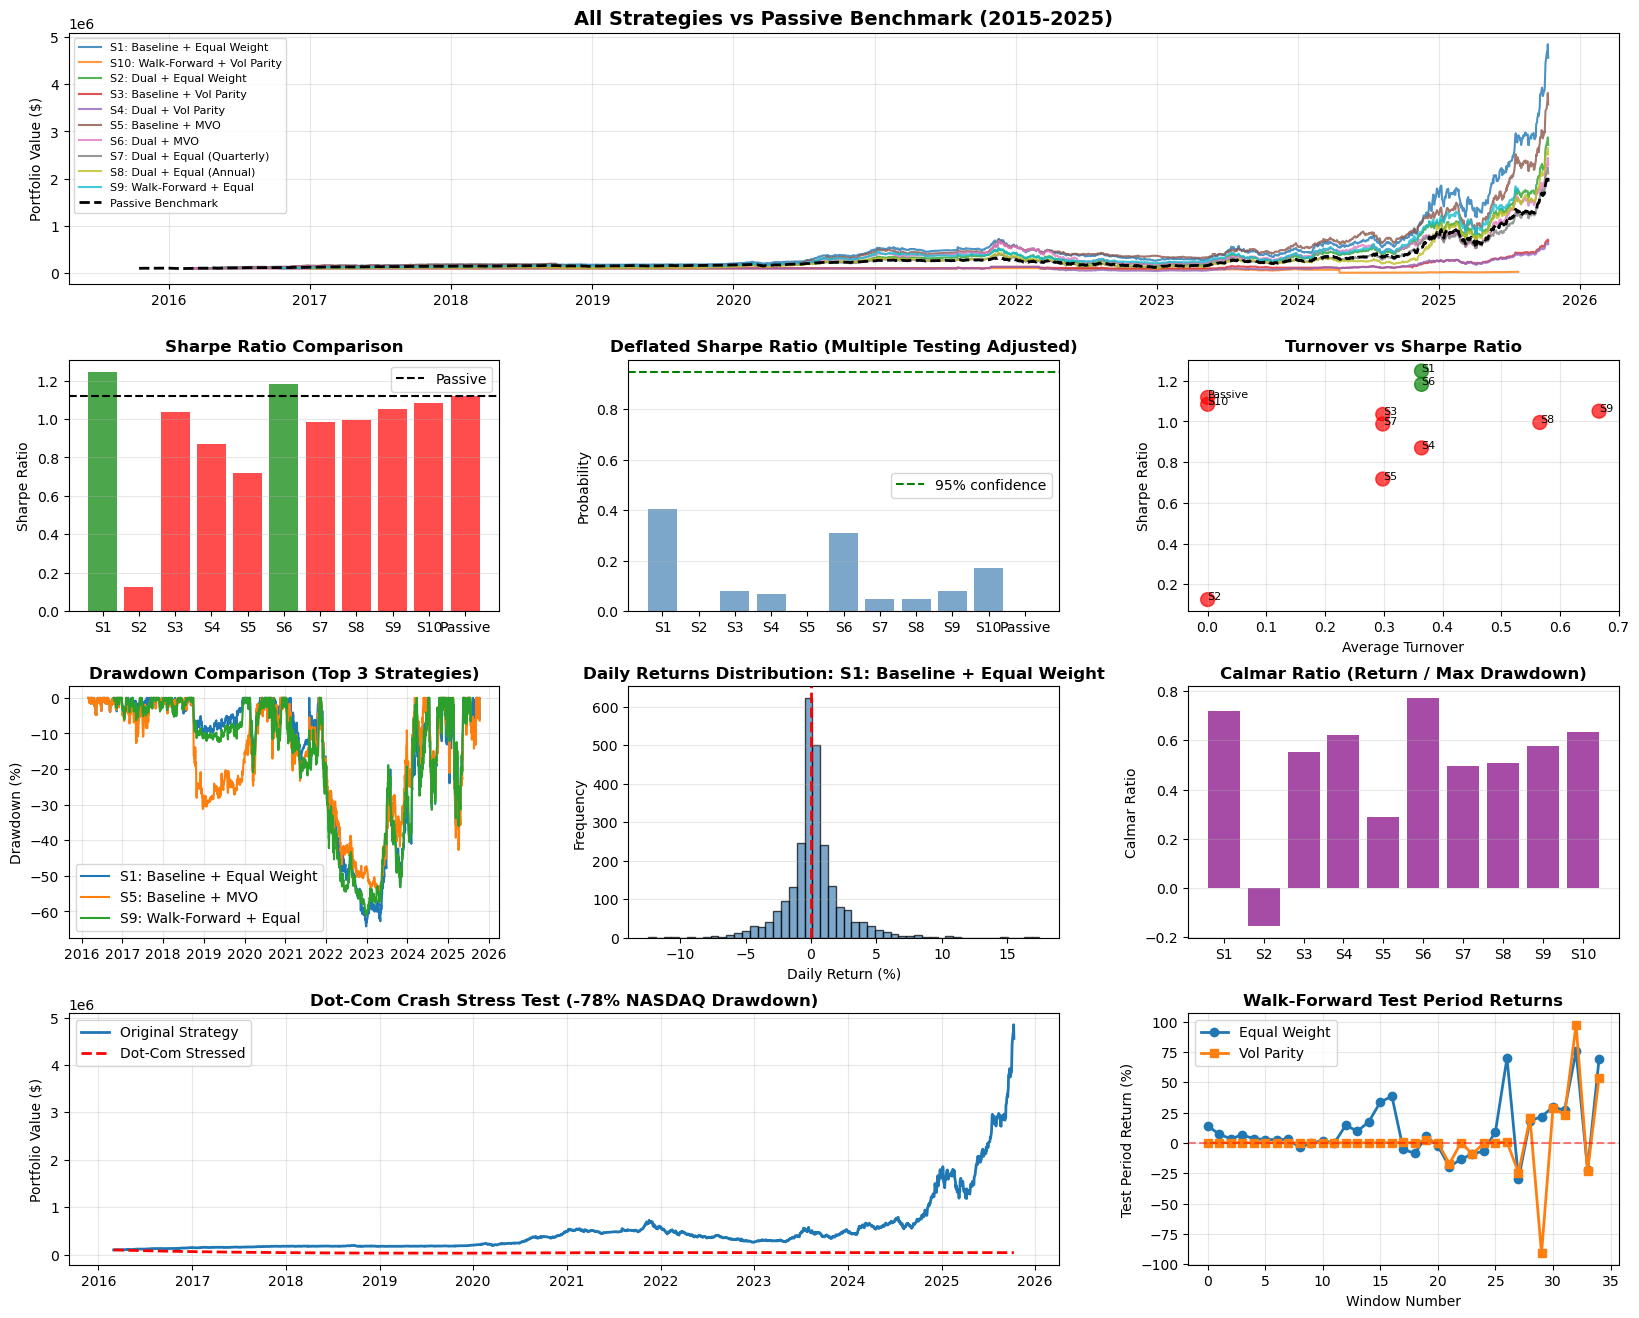

Saved chart to 'attf_phase1_analysis.png'


In [18]:
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
for key in sorted(strategies.keys()):
    ax1.plot(strategies[key]['series'].index, strategies[key]['series'].values, 
            label=strategies[key]['name'], linewidth=1.5, alpha=0.8)
ax1.plot(benchmark_passive.index, benchmark_passive.values, 
        label='Passive Benchmark', linewidth=2, linestyle='--', color='black')
ax1.set_title('All Strategies vs Passive Benchmark (2015-2025)', fontweight='bold', fontsize=14)
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[1, 0])
sharpes = results_df['Sharpe'].values
names = ['S' + str(i+1) for i in range(10)] + ['Passive']
colors = ['green' if s > metrics_passive['sharpe'] else 'red' for s in sharpes]
ax2.bar(names, sharpes, color=colors, alpha=0.7)
ax2.axhline(y=metrics_passive['sharpe'], color='black', linestyle='--', label='Passive')
ax2.set_title('Sharpe Ratio Comparison', fontweight='bold', fontsize=12)
ax2.set_ylabel('Sharpe Ratio')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

ax3 = fig.add_subplot(gs[1, 1])
deflated = results_df['Deflated Sharpe'].values
ax3.bar(names, deflated, color='steelblue', alpha=0.7)
ax3.axhline(y=0.95, color='green', linestyle='--', label='95% confidence')
ax3.set_title('Deflated Sharpe Ratio (Multiple Testing Adjusted)', fontweight='bold', fontsize=12)
ax3.set_ylabel('Probability')
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

ax4 = fig.add_subplot(gs[1, 2])
turnovers = results_df['Turnover'].values
ax4.scatter(turnovers, sharpes, c=colors, s=100, alpha=0.7)
for i, name in enumerate(names):
    ax4.annotate(name, (turnovers[i], sharpes[i]), fontsize=8)
ax4.set_title('Turnover vs Sharpe Ratio', fontweight='bold', fontsize=12)
ax4.set_xlabel('Average Turnover')
ax4.set_ylabel('Sharpe Ratio')
ax4.grid(alpha=0.3)

ax5 = fig.add_subplot(gs[2, 0])
top3_keys = sorted(metrics_dict.keys(), key=lambda k: metrics_dict[k]['sharpe'], reverse=True)[:3]
for key in top3_keys:
    portfolio = strategies[key]['series']
    cum_max = portfolio.expanding().max()
    dd = (portfolio - cum_max) / cum_max * 100
    ax5.plot(dd.index, dd.values, label=strategies[key]['name'], linewidth=1.5)
ax5.set_title('Drawdown Comparison (Top 3 Strategies)', fontweight='bold', fontsize=12)
ax5.set_ylabel('Drawdown (%)')
ax5.legend()
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[2, 1])
best_returns = strategies[top3_keys[0]]['series'].pct_change().dropna() * 100
ax6.hist(best_returns, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax6.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax6.set_title(f'Daily Returns Distribution: {strategies[top3_keys[0]]["name"]}', 
             fontweight='bold', fontsize=12)
ax6.set_xlabel('Daily Return (%)')
ax6.set_ylabel('Frequency')
ax6.grid(alpha=0.3, axis='y')

ax7 = fig.add_subplot(gs[2, 2])
calmars = results_df['Calmar'].values
ax7.bar(names, calmars, color='purple', alpha=0.7)
ax7.set_title('Calmar Ratio (Return / Max Drawdown)', fontweight='bold', fontsize=12)
ax7.set_ylabel('Calmar Ratio')
ax7.grid(alpha=0.3, axis='y')

ax8 = fig.add_subplot(gs[3, :2])
ax8.plot(best_series.index, best_series.values, label='Original Strategy', linewidth=2)
ax8.plot(stressed_series.index, stressed_series.values, label='Dot-Com Stressed', 
        linewidth=2, linestyle='--', color='red')
ax8.set_title('Dot-Com Crash Stress Test (-78% NASDAQ Drawdown)', fontweight='bold', fontsize=12)
ax8.set_ylabel('Portfolio Value ($)')
ax8.legend()
ax8.grid(alpha=0.3)

ax9 = fig.add_subplot(gs[3, 2])
ax9.plot(range(len(wf_results)), wf_results['test_return'].values, 
        marker='o', label='Equal Weight', linewidth=2)
ax9.plot(range(len(wf_results_vp)), wf_results_vp['test_return'].values,
        marker='s', label='Vol Parity', linewidth=2)
ax9.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax9.set_title('Walk-Forward Test Period Returns', fontweight='bold', fontsize=12)
ax9.set_ylabel('Test Period Return (%)')
ax9.set_xlabel('Window Number')
ax9.legend()
ax9.grid(alpha=0.3)

plt.savefig('attf_phase1_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved chart to 'attf_phase1_analysis.png'")

In [19]:
best_key = max(metrics_dict.keys(), key=lambda k: metrics_dict[k]['sharpe'])
best = metrics_dict[best_key]

print("\nBEST STRATEGY:")
print(f"  Name: {best['name']}")
print(f"  Sharpe Ratio: {best['sharpe']:.3f}")
print(f"  Deflated Sharpe: {best['deflated_sharpe']:.3f}")
print(f"  Total Return: {best['total_return']:.2f}%")
print(f"  Annual Return: {best['annual_return']:.2f}%")
print(f"  Max Drawdown: {best['max_dd']:.2f}%")
print(f"  Calmar Ratio: {best['calmar']:.3f}")
print(f"  Alpha vs Passive: {best['alpha']:.2f}%")
print(f"  Average Turnover: {best['turnover']:.2%}")

print("\nPASSIVE BENCHMARK:")
print(f"  Sharpe Ratio: {metrics_passive['sharpe']:.3f}")
print(f"  Total Return: {metrics_passive['total_return']:.2f}%")
print(f"  Annual Return: {metrics_passive['annual_return']:.2f}%")
print(f"  Max Drawdown: {metrics_passive['max_dd']:.2f}%")

print("\nDOT-COM STRESS TEST (SYNTHETIC SCENARIO - NOT HISTORICAL):")
print(f"  Note: This is a simulated drawdown pattern, not actual 2000-2002 data")
print(f"  Stressed Max Drawdown: {stressed_metrics['max_dd']:.2f}%")
print(f"  Stressed Final Return: {stressed_metrics['total_return']:.2f}%")
print(f"  Stressed Sharpe: {stressed_metrics['sharpe']:.3f}")


BEST STRATEGY:
  Name: S1: Baseline + Equal Weight
  Sharpe Ratio: 1.248
  Deflated Sharpe: 0.405
  Total Return: 4458.76%
  Annual Return: 46.16%
  Max Drawdown: -64.20%
  Calmar Ratio: 0.719
  Alpha vs Passive: 11.05%
  Average Turnover: 36.42%

PASSIVE BENCHMARK:
  Sharpe Ratio: 1.118
  Total Return: 1836.84%
  Annual Return: 34.62%
  Max Drawdown: -63.36%

DOT-COM STRESS TEST (SYNTHETIC SCENARIO - NOT HISTORICAL):
  Note: This is a simulated drawdown pattern, not actual 2000-2002 data
  Stressed Max Drawdown: -71.58%
  Stressed Final Return: -57.43%
  Stressed Sharpe: -5.718
